**@author: James V. Talwar**

# PRS Generalization: Comparing MAF across Cohorts

**About:** This notebook provides the code needed to generate **Supplementary Figure 3** from the paper [*Autoimmune Alleles at the Major Histocompatibility Locus Modify Melanoma Susceptibility*](https://www.biorxiv.org/content/10.1101/2021.08.12.456166v1.full). Specifically this notebook evaluates the minor allele frequencies of PRS SNPs across cohorts (TCGA, Melanostrum, and validation). 

This notebook also evaluates whether an association exists between HLA-proximal PRS SNPs and MHC-I allele carrier status.

## 1. Load in Relevant Data and packages:

In [1]:
import pandas as pd
from pathlib import Path
import os
from collections import defaultdict
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy.stats import mannwhitneyu
from scipy import stats
import sys
from statsmodels.stats.multitest import multipletests

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

PRS SNP information and Melanostrum Cohort:

In [2]:
#whyWasThisFileHidden ==  Melanostrum PRS 
whyWasThisFileHidden = pd.read_excel("../Data/Supplementary_Table_3.xlsx" , sep = "\t", skiprows=1) 
whyWasThisFileHidden = whyWasThisFileHidden.drop([i for i in range(204,209)], axis = 0)
temp = [el.replace("*", "") for el in whyWasThisFileHidden.SNP]

whyWasThisFileHidden.index = temp
whyWasThisFileHidden = whyWasThisFileHidden.drop(["SNP"], axis = 1)
whyWasThisFileHidden.head()

,Chr,Loc,Close genes in Genome Browser,"Close genes reported in Law et al., 2015",Weight#,Ref allele for the weight
rs17416005,1.0,10761758.0,CASZ1,NaN,-0.00930,A
rs4655048,1.0,22668770.0,RP11-415K20.1|AL591122.20,NaN,-0.00460,T
rs6679026,1.0,78619511.0,RNFT1P2|RP11-472F19.2|GIPC2,NaN,-0.01700,T
rs11577235,1.0,114113339.0,MTND5P20|RP11-473L1.1|MAGI3,NaN,-0.01400,T
rs491313,1.0,114639042.0,SYT6,NaN,0.00045,C


In [3]:
melanostrumDF = pd.read_excel("../GenotypeData/Supplementary_Table_genotype_data.xlsx", sep = "\t")
melanostrumDF.columns = melanostrumDF.loc[0, :]
melanostrumDF = melanostrumDF.drop([0])

TCGA PRS SNPs and information:

In [4]:
howRiskyAreYou = pd.read_csv("../GenotypeData/SKCM_TCGA_Risk_SNPs.vcf", sep = "\t", skiprows=26)
print(howRiskyAreYou.shape)


(191, 461)


In [5]:
autoimmuneAlleles = {'HLA-B13:02','HLA-B27:05','HLA-B51:01','HLA-B57:01','HLA-C06:02','HLA-C12:03', "HLA-B39:06"} #'HLA-B50:01'

tcgaSummary = pd.read_csv("../GenotypeData/TCGA_Summary_With_BRAFV600E_Mutation_Status.tsv", index_col = 0, sep = "\t")
#Ensure AI Allele Status is correct
tcgaSummary["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in tcgaSummary.iterrows()]

Get intersection of individuals with PRS SNPs and HLA-A,B,C genotypes:

In [6]:
temp = list(howRiskyAreYou.columns) 
temp = temp[:9] + [el.split("_")[0] for el in temp[9:]] #Format columns by TCGA ID
howRiskyAreYou.columns = temp
print(howRiskyAreYou.shape)

(191, 461)


In [7]:
columnsWithoutOverlap = []
for col in list(howRiskyAreYou.columns)[9:]:
    if col not in tcgaSummary.index:
        columnsWithoutOverlap.append(col)

howRiskyAreYou = howRiskyAreYou.drop(columnsWithoutOverlap, axis = 1)
howRiskyAreYou.shape

(191, 447)

UKBB PRS SNPs:

In [8]:
ukbb = pd.read_csv("../GenotypeData/ukbb.205.raw", sep = "\t") 

In [9]:
# All individuals in this UKBB cohort are >= 20 so don't need to prefilter/remove any 
ukbbRelevantIDs = pd.read_csv("../GenotypeData/UKBB.tsv", sep = "\t", index_col=0)
ukbbRelevantIDs["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in ukbbRelevantIDs.iterrows()]

In [10]:
filteredUKBB = ukbb[ukbb.ids.isin(set(ukbbRelevantIDs.index))]
print("Shape of Melanoma UKBB individuals with HLA-Calls is: {}".format(filteredUKBB.shape))

Shape of Melanoma UKBB individuals with HLA-Calls is: (238, 203)


## 2. Pull the MAF in each cohort: 

**Approach:** Map the allele frequency of the risk allele across the PRS for all cohorts and compare against one another

### 2.1 Melanostrum Cohort (original PRS validation set) :

In [11]:
whyWasThisFileHidden.head() #PRS Ref alleles, weights, Positions, etc.

,Chr,Loc,Close genes in Genome Browser,"Close genes reported in Law et al., 2015",Weight#,Ref allele for the weight
rs17416005,1.0,10761758.0,CASZ1,NaN,-0.00930,A
rs4655048,1.0,22668770.0,RP11-415K20.1|AL591122.20,NaN,-0.00460,T
rs6679026,1.0,78619511.0,RNFT1P2|RP11-472F19.2|GIPC2,NaN,-0.01700,T
rs11577235,1.0,114113339.0,MTND5P20|RP11-473L1.1|MAGI3,NaN,-0.01400,T
rs491313,1.0,114639042.0,SYT6,NaN,0.00045,C


In [12]:
melanostrumMAF = defaultdict(float)
numberSNPs = 0
for riskSNP in whyWasThisFileHidden.index:
    localCounter = 0
    totalSNPsObserved = 0
    riskAllele = whyWasThisFileHidden.loc[riskSNP, "Ref allele for the weight"]
    if riskSNP == "rs7164220 (R2=0.6 with rs4778138)": #handle weird indexing issue 
        riskSNP = "rs7164220" 
        
    for genotype in melanostrumDF[riskSNP]:
        if type(genotype) == float: #NaNs --> Skip these in calculating MAF
            continue
        if len(genotype) != 2:
            print("PROBLEMS!!!!!")
            
        #Genotypes are given by a 2 Character string such as 'CG'  
        if genotype[0] == riskAllele:
            localCounter += 1
        if genotype[1] == riskAllele:
            localCounter += 1
        
        totalSNPsObserved += 2 #2 alleles per individual
        
    melanostrumMAF[riskSNP] = localCounter/totalSNPsObserved
    numberSNPs += 1
numberSNPs

204

In [13]:
sorted(melanostrumMAF.items(), key = lambda x: x[1], reverse = True)

[('rs7041168', 0.557753017641597),
 ('rs6909294', 0.525664868885996),
 ('rs2092180', 0.5059696092619392),
 ('rs17823562', 0.5046436863725665),
 ('rs6974622', 0.4958020326999558),
 ('rs9961596', 0.4904608788853162),
 ('rs11686397', 0.487590799031477),
 ('rs954427', 0.4851865398683248),
 ('rs9867857', 0.4844615109841043),
 ('rs6833655', 0.4840145690004047),
 ('rs6021666', 0.4770840851678095),
 ('rs1559943', 0.47617253720097946),
 ('rs10268757', 0.4752224919093851),
 ('rs13338146', 0.46770096171293774),
 ('rs380286', 0.46633327379889267),
 ('rs2111398', 0.4606909430438842),
 ('rs7852450', 0.4597160766961652),
 ('rs4731207', 0.45938808960116556),
 ('rs4457828', 0.45761282159426403),
 ('rs661356', 0.44793713163064836),
 ('rs34680719', 0.44608286593088475),
 ('rs6750047', 0.4389148401006108),
 ('rs12919293', 0.43241517694272164),
 ('rs1554519', 0.4276656545811752),
 ('rs4851781', 0.42641209228321403),
 ('rs1887975', 0.42627149652396634),
 ('rs1464510', 0.4248080014288266),
 ('rs498136', 0.42

### 2.2 TCGA:

In [14]:
whyWasThisFileHidden.head()

,Chr,Loc,Close genes in Genome Browser,"Close genes reported in Law et al., 2015",Weight#,Ref allele for the weight
rs17416005,1.0,10761758.0,CASZ1,NaN,-0.00930,A
rs4655048,1.0,22668770.0,RP11-415K20.1|AL591122.20,NaN,-0.00460,T
rs6679026,1.0,78619511.0,RNFT1P2|RP11-472F19.2|GIPC2,NaN,-0.01700,T
rs11577235,1.0,114113339.0,MTND5P20|RP11-473L1.1|MAGI3,NaN,-0.01400,T
rs491313,1.0,114639042.0,SYT6,NaN,0.00045,C


In [15]:
whichIsWhich = defaultdict(str) #dictionary mapping LOC to ALT+REF alleles
indexesToKeep = set()

for i,row in howRiskyAreYou.iterrows():
    if row["POS"] in whichIsWhich: #should handle the incorrect duplicate issue for one SNP (188112554) on chr3
        continue 
    whichIsWhich[row["POS"]] = row["ALT"] + row["REF"]
    indexesToKeep.add(i) 

locToRSID = dict(zip(whyWasThisFileHidden.Loc, whyWasThisFileHidden.index))

In [16]:
swapCounts = set() #a way to get which SNP counts need to be flipped when the alt allele != the PRS SNP
for k,v in whichIsWhich.items():
    shiftIt = (k-1) in locToRSID
    #make sure no weird key (SNP loc) issues
    if ((k-1) not in locToRSID) and (k not in locToRSID):
        print("KEY ISSUES!!!")
        break
        
    else:
        #check to make sure the alt allele is the PRS allele - if not keep track of which ones need to be swapped (should be 2 of them)
        if (v[0] != whyWasThisFileHidden.loc[locToRSID.get(k - int(shiftIt)), "Ref allele for the weight"]):
            if (v[1] == whyWasThisFileHidden.loc[locToRSID.get(k - int(shiftIt)), "Ref allele for the weight"]):
                swapCounts.add(k)
            else:
                print("WEIRD PROBLEM... neither SNP matches!!!")
                break
                
print("{} SNPs need to be flipped: {}".format(len(swapCounts), swapCounts))

2 SNPs need to be flipped: {42988088, 125073958}


In [17]:
#function to convert a cell to the number of alternate alleles
def Convert(plinkymonGo):
    numAltAlleles = 0
    for alleles in plinkymonGo.split("/"):
        numAltAlleles += int(alleles)
    return numAltAlleles

In [18]:
patientToSNPs = defaultdict(lambda: defaultdict(int))
hasBeenFlipped = 0
for i,row in howRiskyAreYou.iterrows():
    localFlipTrack = False
    for j in howRiskyAreYou.columns[9:]:
        if row["POS"] in swapCounts:
            patientToSNPs[j][row["POS"]] = 2 - Convert(row[j]) #done because need a consistent MAF according to the Risk allele
            localFlipTrack = True
        else: 
            patientToSNPs[j][row["POS"]] = Convert(row[j])
            
    hasBeenFlipped += int(localFlipTrack)
hasBeenFlipped

2

In [19]:
tcgaMAF = defaultdict(float)
for k,v in patientToSNPs.items():
    for location, snpCount in v.items():
        shiftIt = (location-1) in locToRSID
        if ((location-1) not in locToRSID) and (location not in locToRSID):
            raise ValueError("KEY ISSUES!!!")
        
        else:
            #for each patient in TCGA add the number of SNPs of Risk allele divided by 2*total number of tcga individuals
            # --> x2 comes from 2 alleles per individual
            
            tcgaMAF[locToRSID.get(location - int(shiftIt))] += snpCount/(2*len(patientToSNPs))

tcgaMAF["rs7164220"] = tcgaMAF["rs7164220 (R2=0.6 with rs4778138)"]
del tcgaMAF["rs7164220 (R2=0.6 with rs4778138)"]


In [20]:
sorted(tcgaMAF.items(), key = lambda x: x[1])

[('rs187989493', 0.001141552511415525),
 ('rs1464510', 0.003424657534246575),
 ('rs75286671', 0.010273972602739725),
 ('rs250417', 0.010273972602739725),
 ('rs139791480', 0.012557077625570776),
 ('rs72909003', 0.01598173515981735),
 ('rs190036801', 0.017123287671232876),
 ('rs114585466', 0.02054794520547945),
 ('rs118021671', 0.021689497716894976),
 ('rs139410052', 0.0228310502283105),
 ('rs75724758', 0.023972602739726026),
 ('rs146305655', 0.02511415525114155),
 ('rs78161156', 0.02511415525114155),
 ('rs4077700', 0.0273972602739726),
 ('rs185637766', 0.0273972602739726),
 ('rs17132024', 0.0319634703196347),
 ('rs78865622', 0.0365296803652968),
 ('rs72767211', 0.03767123287671233),
 ('rs12427405', 0.04223744292237443),
 ('rs2290419', 0.04337899543378995),
 ('rs117353195', 0.04452054794520548),
 ('rs6938302', 0.04794520547945205),
 ('rs12209946', 0.04794520547945205),
 ('rs62444470', 0.05251141552511415),
 ('rs12595968', 0.05365296803652968),
 ('rs113991941', 0.05821917808219178),
 ('rs

### 2.3 UKBB:

In [21]:
filteredUKBB.shape

(238, 203)

In [22]:
rsid = 0
ukbbLocsOffByOne = set()
for col in filteredUKBB.columns:
    if col == "ids": 
        continue
    try:
        snpLoc = col.split(":")[1].split("_")[0]
        if (int(snpLoc) not in set(whyWasThisFileHidden.Loc)) and (int(snpLoc) - 1 in set(whyWasThisFileHidden.Loc)):
            #print(snpLoc)
            ukbbLocsOffByOne.add(snpLoc)
            #print(col.split(":")[1].split("_")[1])
        elif (int(snpLoc) in set(whyWasThisFileHidden.Loc)):
            print(snpLoc)
        
        else:
            raise ValueError("SNP Indexing Error")
    except:
        rsid += 1
        #print(col)
        
print(rsid) #Need to check that non of the RSIDs collide with the Loc ones
print("Number of SNP locs off by 1 is {}".format(len(ukbbLocsOffByOne))) #All Loc based SNPs are off by 1

16
Number of SNP locs off by 1 is 186


In [23]:
print("If all SNPs are unique, then in total there are {} SNPs".format(filteredUKBB.shape[1] - 1))
uniqueIDs = set()
exceptChecks = 0
duplicates = set()
for col in filteredUKBB.columns:
    if col == "ids": 
        continue
    try:
        #print(col)
        snpLoc = col.split(":")[1].split("_")[0]
        if snpLoc in ukbbLocsOffByOne:
            snpLoc = int(snpLoc) - 1
        else:
            snpLoc = int(snpLoc)
            
        #sanity check to make sure it exists/only one entry
        if whyWasThisFileHidden[whyWasThisFileHidden["Loc"] == snpLoc].shape[0] != 1: 
            print("EEEEEEEEEEEE")
            break
        
        if snpLoc in uniqueIDs:
            duplicates.add(col)
        else:
            uniqueIDs.add(snpLoc)
    except:
        #print(col)
        rsid = col.split("_")[0]
        if rsid == "rs7164220":
            rsid = "rs7164220 (R2=0.6 with rs4778138)"
        snpLoc = whyWasThisFileHidden.loc[rsid, "Loc"]
        if snpLoc in uniqueIDs:
            duplicates.add(col)
        else:
            uniqueIDs.add(snpLoc)
            
        uniqueIDs.add(snpLoc)
        exceptChecks += 1
        
print("Number RSIDs: {}".format(exceptChecks))
print("Number of unique SNPs after sanity checking is: {}".format(len(uniqueIDs)))
duplicates

If all SNPs are unique, then in total there are 202 SNPs
Number RSIDs: 16
Number of unique SNPs after sanity checking is: 201


{'3:188112554_T'}

In [24]:
ukbbMAFs = defaultdict(float)
flipIt = set()
whereAreTheFlipIssues = list()

for col in filteredUKBB.columns: #which SNPs need to be flipped to align to PRS Weight Allele
    if (col == "ids") or (col in duplicates):
        print("Skipping col: {}".format(col))
        continue
        
    if ":" in col: #encoded as a chr:location_SNP
        snpLoc = col.split(":")[1].split("_")[0]
        alleleForCount = col.split(":")[1].split("_")[1]
        if snpLoc in ukbbLocsOffByOne:
            snpLoc = int(snpLoc) - 1
        else:
            snpLoc = int(snpLoc)

        if alleleForCount != whyWasThisFileHidden.loc[locToRSID[snpLoc], "Ref allele for the weight"]:           
            whereAreTheFlipIssues.append(col)
            flipIt.add(col)

    else: #encoded as a rsid_SNP
        #print(col)
        rsid = col.split("_")[0]
        alleleForCount = col.split("_")[1]
        if rsid == "rs7164220":
            rsid = "rs7164220 (R2=0.6 with rs4778138)"
            
        if alleleForCount != whyWasThisFileHidden.loc[rsid, "Ref allele for the weight"]:
            whereAreTheFlipIssues.append(col)
            flipIt.add(col)

print("Need to flip {} SNPs for the UKBB... Calculating MAF now \n".format(len(flipIt)))
print(whereAreTheFlipIssues)
print("\n")

for i,row in filteredUKBB.iterrows(): #Calculate UKBB MAFs
    counter = 0 
    totalFlipped = 0
    for col in filteredUKBB.columns:
        if (col == "ids") or (col in duplicates):
            continue

        counter +=1
        if ":" in col: #encoded as a chr:location_SNP
            snpLoc = col.split(":")[1].split("_")[0]
            if snpLoc in ukbbLocsOffByOne:
                snpLoc = int(snpLoc) - 1
            else:
                snpLoc = int(snpLoc)

            if col in flipIt:
                ukbbMAFs[locToRSID[snpLoc]] += np.round((2 - row[col]))/(2*filteredUKBB.shape[0])
                totalFlipped += 1
            else:
                ukbbMAFs[locToRSID[snpLoc]] += np.round(row[col])/(2*filteredUKBB.shape[0])

        else:  #encoded as a rsid_SNP
            rsid = col.split("_")[0]
            if col in flipIt:
                ukbbMAFs[rsid] +=  np.round((2 - row[col]))/(2*filteredUKBB.shape[0])
                totalFlipped += 1
            else:
                ukbbMAFs[rsid] += np.round(row[col])/(2*filteredUKBB.shape[0])

    if (counter != 201) or (totalFlipped != len(flipIt)):
        print("AYAYAYAY")

print(flipIt)
print(flipIt == set(whereAreTheFlipIssues))

Skipping col: ids
Skipping col: 3:188112554_T
Need to flip 47 SNPs for the UKBB... Calculating MAF now 

['10:73455308_C', '10:105668843_A', '10:119572168_C', '11:6777124_T', '11:10904067_A', '11:69367118_C', '12:3554821_A', '12:17274672_C', '13:23551652_A', '13:27476285_A', '14:94597126_T', '15:24110776_C', 'rs7164220_A', '16:88096203_T', '16:89356701_G', '17:43207858_A', '18:860614_T', '18:42988088_A', '18:45709553_A', '19:3353622_T', '1:162628146_G', '1:204484617_G', '1:205163057_G', 'rs650681_C', '1:236298158_C', 'rs6088092_T', '20:35012486_G', '20:50677206_T', '20:57577935_G', '21:42743496_T', '2:38276549_G', '2:106125082_C', '2:202176294_G', '2:235749373_C', '3:28718712_A', '3:69657736_G', '4:72922675_T', '4:77204500_T', '5:33952378_C', 'rs4865588_A', '6:6405068_C', '6:7115533_A', '8:140029759_A', '9:244457_A', '9:12588950_T', 'rs10739221_C', '9:110698716_T']


{'rs650681_C', '19:3353622_T', '2:106125082_C', '2:202176294_G', '18:860614_T', '2:235749373_C', '20:35012486_G', 'rs486

In [25]:
sorted(ukbbMAFs.items(), key = lambda x: x[1])

[('rs187989493', 0.0021008403361344537),
 ('rs139791480', 0.004201680672268907),
 ('rs250417', 0.0063025210084033615),
 ('rs75286671', 0.010504201680672268),
 ('rs72909003', 0.010504201680672268),
 ('rs114585466', 0.012605042016806721),
 ('rs111461999', 0.014705882352941175),
 ('rs78161156', 0.01680672268907563),
 ('rs139410052', 0.018907563025210083),
 ('rs113991941', 0.021008403361344536),
 ('rs185637766', 0.02310924369747899),
 ('rs4077700', 0.02310924369747899),
 ('rs9392778', 0.02310924369747899),
 ('rs75724758', 0.025210084033613443),
 ('rs118021671', 0.027310924369747896),
 ('rs190036801', 0.027310924369747896),
 ('rs78865622', 0.027310924369747896),
 ('rs17592036', 0.02941176470588235),
 ('rs12209946', 0.02941176470588235),
 ('rs17132024', 0.03571428571428571),
 ('rs146305655', 0.037815126050420166),
 ('rs3773576', 0.04201680672268907),
 ('rs115299550', 0.044117647058823525),
 ('rs2290419', 0.04831932773109243),
 ('rs12427405', 0.04831932773109243),
 ('rs62444470', 0.0504201680

**Sanity Check:** Ensure that there aren't any homozygous SNPs in the entire population - would point to an issue with the file

In [26]:
ukbbAnyEmpty = defaultdict(set)
for col in filteredUKBB.columns:
    if col == "ids" or col in duplicates:
        continue
    ukbbAnyEmpty[col] = set(filteredUKBB[col])

for k,v in ukbbAnyEmpty.items():
    if len(v) <= 1:
        print(k)
        print(v)

## 3. Visualize how the overlapping risk SNP PRS MAFs compare among studies: 

**Approach:** Plot SNP MAFs for each cohort on x and y axes. Expect it to follow a diagonal (i.e. SNP frequencies are similar across all cohorts).

### 3.1 Melanostrum and TCGA:

In [27]:
melanostrum = pd.DataFrame([melanostrumMAF]).T
melanostrum.columns = ["Melanostrum_MAF"]
melanostrum.head()

,Melanostrum_MAF
rs17416005,0.304683
rs4655048,0.157031
rs6679026,0.096310
rs11577235,0.048428
rs491313,0.151290


In [28]:
tcgaAlleleFreq = pd.DataFrame([tcgaMAF]).T
tcgaAlleleFreq.columns = ["TCGA_MAF"]
tcgaAlleleFreq.head()

,TCGA_MAF
rs17416005,0.288813
rs4655048,0.224886
rs6679026,0.119863
rs11577235,0.063927
rs491313,0.173516


In [29]:
tcgaMelanostrum = pd.concat([melanostrum, tcgaAlleleFreq], axis = 1).dropna()
sizeEmUp = list()
for i in tcgaMelanostrum.index:
    if i == "rs7164220": #stupid indexing issue
        i = "rs7164220 (R2=0.6 with rs4778138)"
    sizeEmUp.append(whyWasThisFileHidden.loc[i, "Weight#"])
tcgaMelanostrum["SNP_Weight"] = sizeEmUp
tcgaMelanostrum["Absolute_Weight"] = [abs(el) for el in sizeEmUp]
tcgaMelanostrum["Colors"] = ["positive" if el >= 0 else "negative" for el in tcgaMelanostrum.SNP_Weight] 
tcgaMelanostrum.head()

,Melanostrum_MAF,TCGA_MAF,SNP_Weight,Absolute_Weight,Colors
rs17416005,0.304683,0.288813,-0.00930,0.00930,negative
rs4655048,0.157031,0.224886,-0.00460,0.00460,negative
rs6679026,0.096310,0.119863,-0.01700,0.01700,negative
rs11577235,0.048428,0.063927,-0.01400,0.01400,negative
rs491313,0.151290,0.173516,0.00045,0.00045,positive


Text(0.01, 0.67, 'r = 0.942')

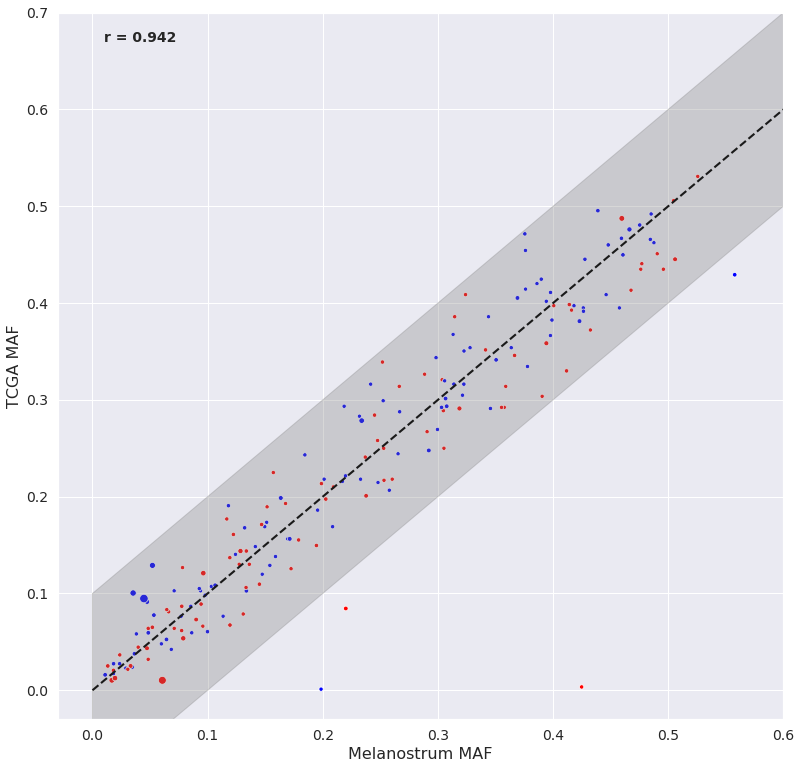

In [30]:
from scipy import stats
def pearsonR(x, y):
    return stats.pearsonr(x, y)[0]

colorMe = {"negative": "red", "positive": "blue"}
sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(13,13))
sns.scatterplot(data = tcgaMelanostrum, x = "Melanostrum_MAF", y = "TCGA_MAF", size = "Absolute_Weight", hue = "Colors", palette=colorMe, legend = False)#s = 66
plt.plot([0,0.6], [0, 0.6], 'k--', lw = 2.1)
ax.fill_between([0,0.6], [0.1,0.7], [-0.1, 0.5], color = "grey", alpha = 0.31)

plt.ylim(-0.03, 0.7)
plt.xlim(-.03, 0.6)

plt.xlabel("Melanostrum MAF", fontsize = 16)
plt.ylabel("TCGA MAF", fontsize = 16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.text(0.01, 0.67, "r = {:.3f}".format(pearsonR(tcgaMelanostrum["Melanostrum_MAF"], tcgaMelanostrum["TCGA_MAF"])), fontweight = "bold", fontsize = 13.9)


Identify all SNPs that have discrepancy of more than 0.1 MAF:

In [31]:
tcgaMelanostrum[abs(tcgaMelanostrum.Melanostrum_MAF - tcgaMelanostrum.TCGA_MAF) >= 0.1]

,Melanostrum_MAF,TCGA_MAF,SNP_Weight,Absolute_Weight,Colors
rs1464510,0.424808,0.003425,-0.010000,0.010000,negative
rs187989493,0.198509,0.001142,0.000061,0.000061,positive
rs7041168,0.557753,0.429224,0.025000,0.025000,positive
rs7164220,0.220004,0.084475,-0.033000,0.033000,negative


### 3.2 Melanostrum and UKBB

In [32]:
ukbbAlleleFreq = pd.DataFrame([ukbbMAFs]).T
ukbbAlleleFreq.columns = ["UKBB_MAF"]
ukbbAlleleFreq.head()

,UKBB_MAF
rs17132024,0.035714
rs139410052,0.018908
rs9787562,0.100840
rs185637766,0.023109
rs3752750,0.315126


In [33]:
ukbbMelanostrum = pd.concat([melanostrum, ukbbAlleleFreq], axis = 1).dropna()
sizeEmUp = list()
for i in ukbbMelanostrum.index:
    if i == "rs7164220": #stupid indexing issue
        i = "rs7164220 (R2=0.6 with rs4778138)"
    sizeEmUp.append(whyWasThisFileHidden.loc[i, "Weight#"])
ukbbMelanostrum["SNP_Weight"] = sizeEmUp
ukbbMelanostrum["Absolute_Weight"] = [abs(el) for el in sizeEmUp]
ukbbMelanostrum["Colors"] = ["positive" if el >= 0 else "negative" for el in ukbbMelanostrum.SNP_Weight] 
ukbbMelanostrum.head()

,Melanostrum_MAF,UKBB_MAF,SNP_Weight,Absolute_Weight,Colors
rs17416005,0.304683,0.260504,-0.00930,0.00930,negative
rs4655048,0.157031,0.235294,-0.00460,0.00460,negative
rs6679026,0.096310,0.123950,-0.01700,0.01700,negative
rs11577235,0.048428,0.075630,-0.01400,0.01400,negative
rs491313,0.151290,0.205882,0.00045,0.00045,positive


(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]),
 <a list of 9 Text yticklabel objects>)

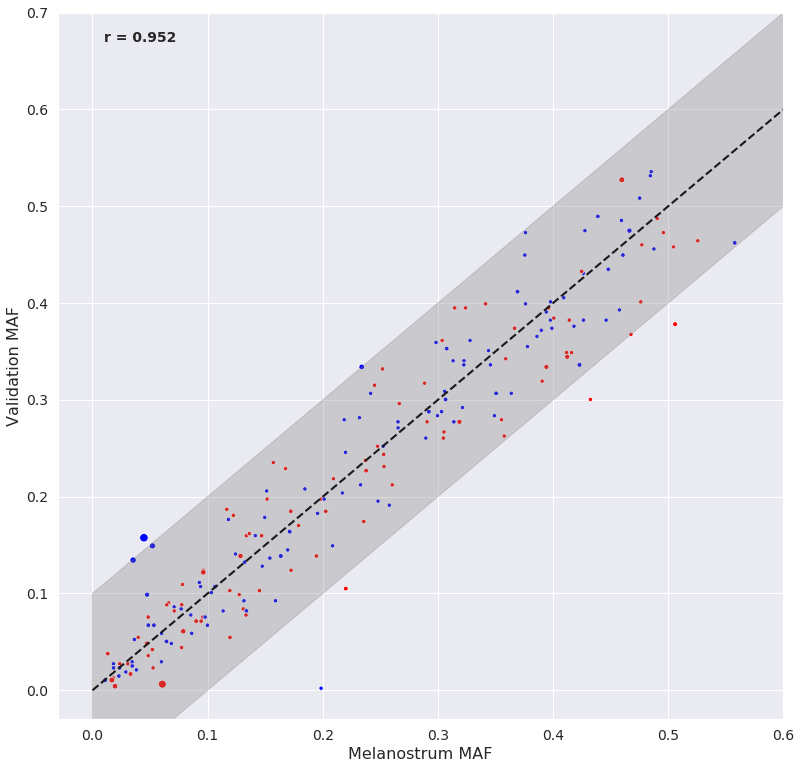

In [34]:
fig, ax = plt.subplots(figsize=(13,13))
sns.set(font_scale=1.1)
sns.scatterplot(data = ukbbMelanostrum, x = "Melanostrum_MAF", y = "UKBB_MAF", hue = "Colors", size = "Absolute_Weight", palette=colorMe, legend = False) #, s = 66)
plt.plot([0,0.6], [0, 0.6], 'k--', lw = 2.1)
ax.fill_between([0,0.6], [0.1,0.7], [-0.1, 0.5], color = "grey", alpha = 0.31)

plt.xlabel("Melanostrum MAF", fontsize = 16)
plt.ylabel("Validation MAF", fontsize = 16)
plt.ylim(-0.03, 0.7)
plt.xlim(-.03, 0.6)
plt.text(0.01, 0.67, "r = {:.3f}".format(pearsonR(ukbbMelanostrum["Melanostrum_MAF"], ukbbMelanostrum["UKBB_MAF"])), fontweight = "bold", fontsize = 13.9)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Identify all SNPs that have discrepancy of more than 0.1 MAF:

In [35]:
ukbbMelanostrum[abs(ukbbMelanostrum.Melanostrum_MAF - ukbbMelanostrum.UKBB_MAF) >= 0.1]

,Melanostrum_MAF,UKBB_MAF,SNP_Weight,Absolute_Weight,Colors
rs187989493,0.198509,0.002101,0.000061,0.000061,positive
rs1393350,0.233792,0.334034,0.120000,0.120000,positive
rs7164220,0.220004,0.105042,-0.033000,0.033000,negative
rs13338146,0.467701,0.367647,-0.001700,0.001700,negative
rs12919293,0.432415,0.300420,-0.001400,0.001400,negative
rs75570604,0.044665,0.157563,0.490000,0.490000,positive
rs2092180,0.505970,0.378151,-0.048000,0.048000,negative


In [36]:
ukbbMelanostrumOutlierSNPs = set(ukbbMelanostrum[abs(ukbbMelanostrum.Melanostrum_MAF - ukbbMelanostrum.UKBB_MAF) >= 0.1].index)

In [37]:
print("The number of MAF outlier SNPs is {}".format(ukbbMelanostrum[abs(ukbbMelanostrum.Melanostrum_MAF - ukbbMelanostrum.UKBB_MAF) >= 0.1].shape[0]))

The number of MAF outlier SNPs is 7


### 3.3 TCGA and UKBB:

In [38]:
tcgaUKBB = pd.concat([tcgaAlleleFreq, ukbbAlleleFreq], axis = 1).dropna()
print("The SNP overlap between TCGA and UKBB is {}/{}".format(tcgaUKBB.shape[0],tcgaAlleleFreq.shape[0])) #190 is the minimum of the 2 SNP sets
sizeEmUp = list()
for i in tcgaUKBB.index:
    if i == "rs7164220": #stupid indexing issue
        i = "rs7164220 (R2=0.6 with rs4778138)"
    sizeEmUp.append(whyWasThisFileHidden.loc[i, "Weight#"])
tcgaUKBB["SNP_Weight"] = sizeEmUp
tcgaUKBB["Absolute_Weight"] = [abs(el) for el in sizeEmUp]
tcgaUKBB["Colors"] = ["positive" if el >= 0 else "negative" for el in tcgaUKBB.SNP_Weight] 
tcgaUKBB.head()

The SNP overlap between TCGA and UKBB is 189/190


,TCGA_MAF,UKBB_MAF,SNP_Weight,Absolute_Weight,Colors
rs17416005,0.288813,0.260504,-0.00930,0.00930,negative
rs4655048,0.224886,0.235294,-0.00460,0.00460,negative
rs6679026,0.119863,0.123950,-0.01700,0.01700,negative
rs11577235,0.063927,0.075630,-0.01400,0.01400,negative
rs491313,0.173516,0.205882,0.00045,0.00045,positive


(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7]),
 <a list of 9 Text yticklabel objects>)

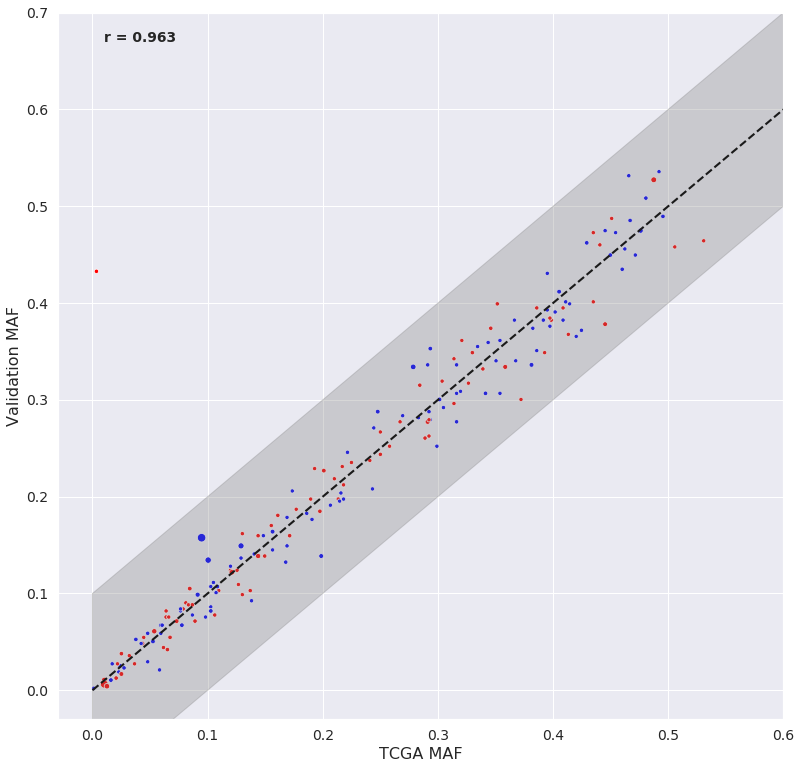

In [39]:
fig, ax = plt.subplots(figsize=(13,13))
sns.set(font_scale=1.1)
sns.scatterplot(data = tcgaUKBB, x = "TCGA_MAF", y = "UKBB_MAF", hue = "Colors", size = "Absolute_Weight", palette=colorMe, legend = False) #color = "m", s = 66)
plt.plot([0,0.6], [0, 0.6], 'k--', lw = 2.1)
ax.fill_between([0,0.6], [0.1,0.7], [-0.1, 0.5], color = "grey", alpha = 0.31)

plt.xlabel("TCGA MAF", fontsize = 16)
plt.ylabel("Validation MAF", fontsize = 16)
#plt.title("UKBB vs. TCGA: MAF Comparison", y = 1.01, fontsize = 19)
plt.text(0.01, 0.67, "r = {:.3f}".format(pearsonR(tcgaUKBB["TCGA_MAF"], tcgaUKBB["UKBB_MAF"])), fontweight = "bold", fontsize = 13.9)
plt.ylim(-0.03, 0.7)
plt.xlim(-.03, 0.6)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


Identify all SNPs that have discrepancy of more than 0.1 MAF:

In [40]:
tcgaUKBB[abs(tcgaUKBB.TCGA_MAF - tcgaUKBB.UKBB_MAF) >= 0.1]

,TCGA_MAF,UKBB_MAF,SNP_Weight,Absolute_Weight,Colors
rs1464510,0.003425,0.432773,-0.01,0.01,negative


In [41]:
print("The maximum effect SNP has a weight of {}".format(max(tcgaUKBB.SNP_Weight)))
print("The minimum effect SNP has a weight of {}".format(min(tcgaUKBB.SNP_Weight)))

The maximum effect SNP has a weight of 0.49
The minimum effect SNP has a weight of -0.4


### Do PRS SNPs close to MHC-I show an association with MHC-I AI genotype?

Look at SNPs on chromosome 6 and run Fisher's exact test

Load in TCGA Summary DF with HLA-types and AI allele status:

In [42]:
print(sum(tcgaSummary.HasProtection))
tcgaSummary = tcgaSummary[tcgaSummary.Age >= 20] #only looking at >= 20 individuals!
print(sum(tcgaSummary.HasProtection))

193
190


In [43]:
tcgaSummary = tcgaSummary[tcgaSummary.index.isin(howRiskyAreYou.columns)]
tcgaSummary.shape

(433, 14)

Get the HLA-genotypes:

In [44]:
chromosome6Only = howRiskyAreYou[howRiskyAreYou["#CHROM"] == 6] 
for i,row in chromosome6Only.iterrows():
    minorAlleleCounts = list()
    for inds in tcgaSummary.index:  
        minorAlleleCounts.append(Convert(row[inds]))
    tcgaSummary[row["ID"]] = minorAlleleCounts
print(tcgaSummary.shape)

(433, 28)


Run the chromosome 6 associations with Autoimmune allele status:

In [45]:
prsMHCSNPAssociations = defaultdict(lambda: defaultdict(list))
for col in tcgaSummary[[el for el in tcgaSummary.columns if ":" in el]]: #the SNPs 
    aiMinAllele = sum(tcgaSummary[tcgaSummary.HasProtection][col])
    aiMajAllele = sum([2 - el for el in tcgaSummary[tcgaSummary.HasProtection][col]])
    noAIMinAllele = sum(tcgaSummary[~tcgaSummary.HasProtection][col])
    noAIMajAllele = sum([2 - el for el in tcgaSummary[~tcgaSummary.HasProtection][col]])
    
    if(aiMajAllele + aiMinAllele + noAIMajAllele + noAIMinAllele != tcgaSummary.shape[0]*2):
        raise ValueError("SNP counts are incorrect - total SNPs should == {}".format(tcgaSummary.shape[0]*2))
    
    table = [[aiMinAllele, noAIMinAllele],[aiMajAllele, noAIMajAllele]]
    
    oddsRatio, pSnpVal = stats.fisher_exact(table)
    prsMHCSNPAssociations[col]["OR"] = oddsRatio
    prsMHCSNPAssociations[col]["p"] = pSnpVal
    
    if pSnpVal < 0.05:
        print(col)
        print(table)
        print("\n")

Seems none are significant - correct anyway though:

In [46]:
#grch37 coordinates:
hlaBBegin = 31321649
hlaBEnd = 31324965
hlaCBegin = 31236526 #https://grch37.ensembl.org/Homo_sapiens/Gene/Summary?g=ENSG00000204525;r=6:31236526-31239907
hlaCEnd = 31239907
hlaABegin = 29898024
hlaAEnd = 29902665
rangeOfHLA = [hlaBBegin, hlaBEnd, hlaABegin, hlaAEnd, hlaCBegin, hlaCEnd]
proximalHLASNPs = chromosome6Only[(abs(chromosome6Only["POS"] - max(rangeOfHLA)) <= 3e6) | ((abs(chromosome6Only["POS"] - min(rangeOfHLA)) <= 3e6))]
#proximalHLASNPs

In [47]:
snpOrdering = [el[0] for el in sorted(prsMHCSNPAssociations.items(), key = lambda x: x[1]["p"]) if el[0] in set(proximalHLASNPs.ID)]
pValues = [el[1]["p"] for el in sorted(prsMHCSNPAssociations.items(), key = lambda x: x[1]["p"]) if el[0] in set(proximalHLASNPs.ID)]
mhCorrected = multipletests(pvals = pValues, alpha = 0.05, method = "fdr_bh")
mhCorrected

(array([False, False, False]),
 array([0.235189  , 0.74228973, 0.74228973]),
 0.016952427508441503,
 0.016666666666666666)